In [1]:
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
from dem_stitcher.geojson_io import read_geojson_gzip
from shapely.geometry import Polygon, shape
import asf_search as asf
import concurrent.futures
from tqdm import tqdm
import mpire
import backoff
import requests
import contextily as cx

In [2]:
START_DATE = '2020-01-01'
END_DATE = '2022-01-01'
MINIMUM_SAMPLES_PER_SITE_AND_BURST = 55 # for prior to December 21, 2021 we expect ~60 samples per year
N_TROPICAL_SITES = 10
TROPICAL_BUFFER_DEG = 5

# Read the disturbance Data

In [3]:
df_dist_hls_val = pd.read_csv('https://raw.githubusercontent.com/OPERA-Cal-Val/DIST-Validation/main/referenceTimeSeries_last.csv')
df_dist_hls_val.head()

,ID,overallLabel,Long,Lat,changetype,20211001,20211002,20211003,20211004,20211005,...,20220921,20220922,20220923,20220924,20220925,20220926,20220927,20220928,20220929,20220930
0,1,VLmaj,-52.379792,-23.297147,Natural browning,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs,noObs
1,2,noChange,129.850328,-29.577240,No Change,noObs,noObs,noObs,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
2,3,VLmin,-98.600559,33.771004,Natural browning,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
3,4,VLmaj,19.332894,4.574903,Fire,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noChange,noChange,noChange,noObs,noObs,noObs
4,5,VLmaj,115.619006,63.108089,Fire,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs


# Extracting "change" and Last observed "no change" indices

In [4]:
def get_index(data: list[str], val: str) -> int:
    try:
        ind = data.index(val)
    except ValueError:
        ind = len(data)
    return ind


def get_first_change(labeled_ts):
    get_index_p = lambda val: get_index(labeled_ts, val)
    indices = list(map(get_index_p, ['VLmin', 'VLmaj', 'OCmin', 'OCmaj']))
    ind = min(indices)
    ind = ind if ind < len(labeled_ts) else -1
    return ind

def get_last_noChange(labeled_ts, change_ind):
    if change_ind == -1:
        return -1
    labeled_ts_r = (labeled_ts[:change_ind][::-1])
    ind_nc_r = get_index(labeled_ts_r, 'noChange')
    ind_nc = change_ind - ind_nc_r - 1
    return ind_nc

Debugging/testing

In [5]:
IND_T = 2
row_data = list(df_dist_hls_val.iloc[IND_T])
ts_labeled = row_data[5:]
ind_c = get_first_change(ts_labeled)
ts_labeled[max(ind_c-10, 0): ind_c+10], ind_c

(['noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin'],
 119)

In [6]:
ind_nc = get_last_noChange(ts_labeled, ind_c)
ts_labeled[max(ind_nc, 0) : ind_c+ 1], ind_c

(['noChange',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'VLmin'],
 119)

## Extract dates from Table

In [7]:
def get_first_change_from_row(row):
    change_label = row['overallLabel']
    if change_label in ['VLmin', 'VLmaj', 'OCmaj', 'OCmin']:
        dates_str = row.keys().tolist()[5:]
        dates = pd.to_datetime(dates_str)
        
        labeled_ts = list(row)[5:]
        ind_c = get_first_change(labeled_ts)
        change_date = dates[ind_c]
    else:
        change_date = pd.NaT
    return change_date

def get_last_obs_date_before_change(row):
    change_label = row['overallLabel']
    if change_label in ['VLmin', 'VLmaj', 'OCmaj', 'OCmin']:
        dates_str = row.keys().tolist()[5:]
        dates = pd.to_datetime(dates_str)
        
        labeled_ts = list(row)[5:]
        ind_c = get_first_change(labeled_ts)
        ind_nc = get_last_noChange(labeled_ts, ind_c)
        last_obs_date = dates[ind_nc] if ind_nc > -1 else pd.NaT
    else:
        last_obs_date = pd.NaT

    return last_obs_date


In [8]:
df_dist_hls_val.head()

,ID,overallLabel,Long,Lat,changetype,20211001,20211002,20211003,20211004,20211005,...,20220921,20220922,20220923,20220924,20220925,20220926,20220927,20220928,20220929,20220930
0,1,VLmaj,-52.379792,-23.297147,Natural browning,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs,noObs
1,2,noChange,129.850328,-29.577240,No Change,noObs,noObs,noObs,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
2,3,VLmin,-98.600559,33.771004,Natural browning,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
3,4,VLmaj,19.332894,4.574903,Fire,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noChange,noChange,noChange,noObs,noObs,noObs
4,5,VLmaj,115.619006,63.108089,Fire,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs


In [9]:
change_times = df_dist_hls_val.apply(get_first_change_from_row, axis=1)
last_obs_times = df_dist_hls_val.apply(get_last_obs_date_before_change, axis=1)
change_labels = df_dist_hls_val.overallLabel[:10]
print(list(zip(change_times,last_obs_times, change_times > last_obs_times ,change_labels)))

[(Timestamp('2021-10-08 00:00:00'), NaT, False, 'VLmaj'), (NaT, NaT, False, 'noChange'), (Timestamp('2022-01-28 00:00:00'), Timestamp('2022-01-06 00:00:00'), True, 'VLmin'), (Timestamp('2021-11-07 00:00:00'), Timestamp('2021-11-02 00:00:00'), True, 'VLmaj'), (Timestamp('2022-05-18 00:00:00'), Timestamp('2022-05-11 00:00:00'), True, 'VLmaj'), (Timestamp('2021-10-03 00:00:00'), NaT, False, 'VLmaj'), (NaT, NaT, False, 'noChange'), (Timestamp('2021-11-12 00:00:00'), Timestamp('2021-11-03 00:00:00'), True, 'OCmin'), (NaT, NaT, False, 'noChange'), (NaT, NaT, False, 'noChange')]


In [10]:
df_sites = gpd.GeoDataFrame({'site_id': df_dist_hls_val.ID,
                             'change_label': df_dist_hls_val.overallLabel,
                             'change_time': change_times,
                             'last_observation_time': last_obs_times},
                             geometry=gpd.points_from_xy(df_dist_hls_val.Long,
                                                         df_dist_hls_val.Lat),
                            crs=CRS.from_epsg(4326))

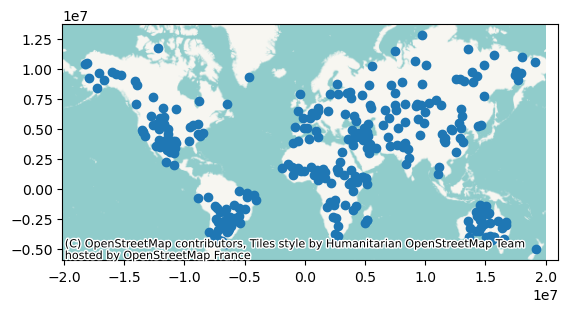

In [11]:
ax = df_sites.to_crs(epsg=3857).plot()
cx.add_basemap(ax)

In [12]:
df_sites.to_file('dist_hls_val_sites.geojson', driver='GeoJSON')

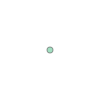

In [13]:
site_lut = df_sites[['site_id', 'geometry']].set_index('site_id').to_dict()
site_lut['geometry'][1]

# Burst Ids

In [14]:
df_burst = read_geojson_gzip('../1_visualize_rtc_time_series/opera_burst_ids.geojson.zip')
df_burst.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass
0,"POLYGON ((2.53190 4.75701, 3.29631 4.91201, 3....",t001_000025_iw1,1,False,ASCENDING
1,"POLYGON ((3.25912 4.97460, 4.06055 5.13657, 4....",t001_000025_iw2,1,False,ASCENDING
2,"POLYGON ((4.02659 5.18854, 4.73485 5.32978, 4....",t001_000025_iw3,1,False,ASCENDING
3,"POLYGON ((2.49611 4.92361, 3.26087 5.07851, 3....",t001_000026_iw1,1,False,ASCENDING
4,"POLYGON ((3.22392 5.14115, 4.02565 5.30297, 3....",t001_000026_iw2,1,False,ASCENDING


# Join Burst table and the site ids

Via a spatial join

In [15]:
df_val_bursts = gpd.sjoin(df_burst, df_sites, how='inner', predicate='intersects').reset_index(drop=True)
df_val_bursts = df_val_bursts.drop_duplicates()
df_val_bursts = df_val_bursts.drop(columns=['index_right'])
df_val_bursts['track_number'] = df_val_bursts.burst_id_jpl.map(lambda burst_id_jpl: int(burst_id_jpl.split('_')[0][1:]))
df_val_bursts = df_val_bursts.sort_values(by=['site_id', 'burst_id_jpl']).reset_index(drop=True)
df_val_bursts.rename(columns={'burst_id_jpl': 'jpl_burst_id'}, inplace=True)
df_val_bursts.head()

,geometry,jpl_burst_id,is_land,is_north_america,orbit_pass,site_id,change_label,change_time,last_observation_time,track_number
0,"POLYGON ((-52.73133 -23.43816, -51.90414 -23.2...",t090_193169_iw1,1,False,ASCENDING,1,VLmaj,2021-10-08,NaT,90
1,"POLYGON ((-51.66339 -23.30842, -52.52125 -23.1...",t097_207419_iw2,1,False,DESCENDING,1,VLmaj,2021-10-08,NaT,97
2,"POLYGON ((-53.01716 -23.54912, -52.25936 -23.3...",t163_349964_iw3,1,False,ASCENDING,1,VLmaj,2021-10-08,NaT,163
3,"POLYGON ((129.82540 -29.63759, 130.62076 -29.4...",t039_083584_iw3,1,False,ASCENDING,2,noChange,NaT,NaT,39
4,"POLYGON ((130.49640 -29.60892, 129.63063 -29.4...",t075_160202_iw1,1,False,DESCENDING,2,noChange,NaT,NaT,75


In [16]:
df_val_bursts.shape

(1117, 10)

<Axes: >

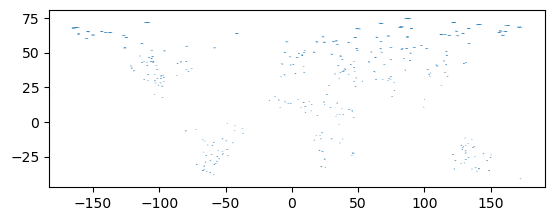

In [17]:
df_val_bursts.plot()

Serializing all the bursts.

In [18]:
df_val_bursts.to_file('dist_val_bursts.geojson', driver='GeoJSON')

# Multiple bursts overlapping

This is particlarly present at high latitudes. We see multiple tracks overlap. We see that there are 11 distinct bursts overlapping site 80!

In [19]:
df_burst_count = df_val_bursts[['site_id', 'orbit_pass']].groupby('site_id').count().sort_values(by='orbit_pass', ascending=False).reset_index(drop=False)
df_burst_count.head(10)

,site_id,orbit_pass
0,80,11
1,36,10
2,45,9
3,85,9
4,49,9
5,157,9
6,81,8
7,71,8
8,39,8
9,218,8


<Axes: >

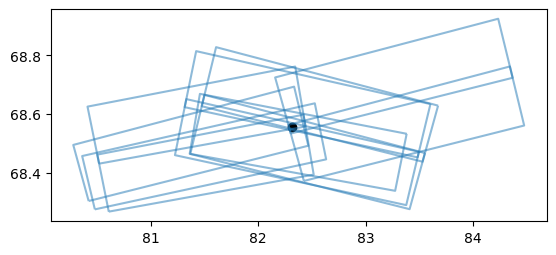

In [20]:
fig, ax = plt.subplots()
df_site = df_sites[df_sites.site_id == 80].plot(ax=ax, color='black')
df_val_bursts[df_val_bursts.site_id == 80].exterior.plot(ax=ax, alpha=.5)

We can better select a suitable burst by calculating the distance from the burst centroid to the Site. This helps find bursts that will likely give us as much context about the site as possible.

In [21]:
def distance_to_site_burst(row):
    poly_cent = row['geometry'].centroid
    site_id = row['site_id']
    site_geo = site_lut['geometry'][site_id]

    dist = site_geo.distance(poly_cent)
    return dist

The sorting of the data

In [22]:
df_val_bursts['dist_from_site_to_burst_centroid'] = df_val_bursts.apply(distance_to_site_burst, axis=1)
df_val_bursts.sort_values(by=['site_id', 'orbit_pass','dist_from_site_to_burst_centroid'], inplace=True)

## Get only 1 bursts from ASC/DSC

Since the data is now ordered by its proximity to the site, we can select the topmost entry in each group of `site_id` and `orbit_pass` (i.e. ascending/descending).

In [23]:
df_val_bursts_filtered = df_val_bursts.groupby(['site_id', 'orbit_pass']).head(1).reset_index(drop=True)
df_val_bursts_filtered.shape, df_val_bursts.shape

((600, 11), (1117, 11))

<Axes: >

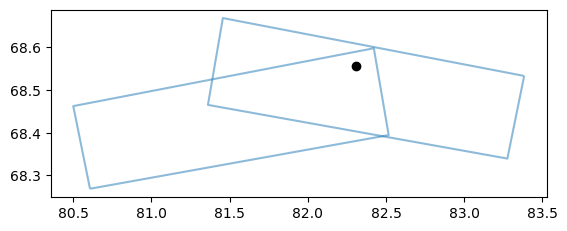

In [24]:
fig, ax = plt.subplots()
df_site = df_sites[df_sites.site_id == 80].plot(ax=ax, color='black')
df_val_bursts_filtered[df_val_bursts_filtered.site_id == 80].exterior.plot(ax=ax, alpha=.5)

# Getting SLC IDs

Now that we have the burst for each ascending/descending pass we will use, we query the ASF DAAC for the SLC metadata we need.

In [25]:
@backoff.on_exception(backoff.expo,
                      (requests.exceptions.ReadTimeout,
                       requests.exceptions.ConnectionError,
                      RuntimeError))
def get_asf_results(*,geo: Point,
                    site_id: int,
                    track_number: int,
                    jpl_burst_id: str,
                    **kwargs):
    
    res = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1],
                         intersectsWith=geo.wkt,
                         #maxResults=5_000,
                         polarization=['VV+VH'], # could add just 'VV'
                         beamMode=[asf.BEAMMODE.IW],
                         relativeOrbit=[track_number],
                         processingLevel=[asf.PRODUCT_TYPE.SLC],
                         start=START_DATE,
                         end=END_DATE
                         )
    df_res = pd.DataFrame()
    if res:
        geometry = [shape(r.geojson()['geometry']) for r in res]
        data = [r.properties for r in res]

        df_res = pd.DataFrame(data)
        df_res = gpd.GeoDataFrame(df_res,
                                  geometry=geometry,
                                  crs=CRS.from_epsg(4326))
        df_res['site_id'] = site_id
        df_res['jpl_burst_id'] = jpl_burst_id

    return df_res

def get_asf_results_from_record(record) -> gpd.GeoDataFrame:
    df = get_asf_results(geo=record['geometry'], site_id=record['site_id'], track_number=record['track_number'], jpl_burst_id=record['jpl_burst_id'])
    return df

We want the site point for the query as it's more exact.

In [26]:
df_query = df_val_bursts_filtered.copy()
df_query = df_query.drop(columns=['geometry'])
df_query = pd.merge(df_query, df_sites[['site_id', 'geometry']], how='left', on='site_id')
df_query.shape

(600, 11)

In [27]:
records = df_query.to_dict('records')
records[:2]

[{'jpl_burst_id': 't090_193169_iw1',
  'is_land': 1,
  'is_north_america': False,
  'orbit_pass': 'ASCENDING',
  'site_id': 1,
  'change_label': 'VLmaj',
  'change_time': Timestamp('2021-10-08 00:00:00'),
  'last_observation_time': NaT,
  'track_number': 90,
  'dist_from_site_to_burst_centroid': 0.06483761782334214,
  'geometry': <POINT (-52.38 -23.297)>},
 {'jpl_burst_id': 't097_207419_iw2',
  'is_land': 1,
  'is_north_america': False,
  'orbit_pass': 'DESCENDING',
  'site_id': 1,
  'change_label': 'VLmaj',
  'change_time': Timestamp('2021-10-08 00:00:00'),
  'last_observation_time': NaT,
  'track_number': 97,
  'dist_from_site_to_burst_centroid': 0.258935889989853,
  'geometry': <POINT (-52.38 -23.297)>}]

In [28]:
get_asf_results_from_record(records[4]).head(2)

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,processingDate,sensor,groupID,pgeVersion,fileName,beamModeType,s3Urls,geometry,site_id,jpl_burst_id
0,34.3598,-99.0311,2021-12-23T00:36:53Z,S1A_IW_SLC__1SDV_20211223T003625_20211223T0036...,ASCENDING,107,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2021-12-23T00:36:25Z,S1A_IW_SLC__1SDV_20211223T003625_20211223T0036...,...,2021-12-23T00:36:25Z,C-SAR,S1A_IWDV_0107_0114_041129_107,003.40,S1A_IW_SLC__1SDV_20211223T003625_20211223T0036...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((-100.59006 34.99121, -100.19687 33.3...",3,t107_227877_iw2
1,34.3599,-99.0325,2021-12-11T00:36:54Z,S1A_IW_SLC__1SDV_20211211T003626_20211211T0036...,ASCENDING,107,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2021-12-11T00:36:26Z,S1A_IW_SLC__1SDV_20211211T003626_20211211T0036...,...,2021-12-11T00:36:26Z,C-SAR,S1A_IWDV_0107_0114_040954_107,003.40,S1A_IW_SLC__1SDV_20211211T003626_20211211T0036...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((-100.59154 34.99142, -100.19825 33.3...",3,t107_227877_iw2


In [29]:
#dfs = list(map(get_asf_results_from_record, tqdm(records)))

In [ ]:
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    dfs = list(tqdm(executor.map(get_asf_results_from_record, records[:]), total=len(records)))

  6%|███▊                                                               | 34/600 [02:01<24:35,  2.61s/it]

In [ ]:
df_slcs = pd.concat(dfs, axis=0)
df_slcs.head()

Serialize the asf data and remove the `s3Urls` because they require 

In [ ]:
df_slcs[[c for c in df_slcs.columns if c not in ['s3Urls']]].to_file('slcs_resp.geojson', driver='GeoJSON',)

# Filtering the SLC data

First we read the data we have serialized (so we don't have to unnecessarily query ASF).

In [ ]:
df_slcs = gpd.read_file('slcs_resp.geojson')

Let's first observe there are multiple SLCs for a given pass.

In [ ]:
df_slcs['date_acquired_str'] = pd.to_datetime(df_slcs['startTime']).dt.date.map(str)
df_slcs.sort_values(by=['site_id', 'jpl_burst_id', 'date_acquired_str'], inplace=True)

We really only want one SLC for a given burst and date/pass.

In [ ]:
df_slcs['date_acquired_str'] = pd.to_datetime(df_slcs['startTime']).dt.date.map(str)
df_slc_per_date_count = df_slcs[['jpl_burst_id', 'date_acquired_str', 'site_id', 'fileID']].groupby(['jpl_burst_id', 'date_acquired_str', 'site_id']).count().sort_values(by='fileID', ascending=False).reset_index(drop=False)
df_slc_per_date_count.iloc[:2]

In [ ]:
# df_slcs[df_slcs.jpl_burst_id == 't021_043849_iw2'].head()

There are some sites that actually share bursts/SLCs. An example of two sites with shared burst and 2 SLCs.

In [ ]:
df_slcs[(df_slcs.jpl_burst_id == 't042_088909_iw2') & (df_slcs.date_acquired_str == '2021-08-14')][['site_id', 'jpl_burst_id', 'fileID']]

In [ ]:
fig, ax = plt.subplots()

df_sites[df_sites.site_id.isin([166, 117])].plot(ax=ax)
df_slcs[(df_slcs.jpl_burst_id == 't042_088909_iw2') & (df_slcs.date_acquired_str == '2021-08-14')].exterior.plot(ax=ax)

### Filtering the SLCs by proximity to Site

Again, we can order the SLCs within flight direction (ascending/descending) and site according to the SLCs proximity to the site.

In [ ]:
def distance_to_site_slc(row):
    poly_cent = row['geometry'].centroid
    site_id = row['site_id']
    site_geo = site_lut['geometry'][site_id]

    dist = site_geo.distance(poly_cent)
    return dist

In [ ]:
df_slcs['dist_from_site_to_slc_centroid'] = df_slcs.apply(distance_to_site_slc, axis=1)
df_slcs[(df_slcs.jpl_burst_id == 't042_088909_iw2') & (df_slcs.date_acquired_str == '2021-08-14')]

In [ ]:
df_slcs.sort_values(by=['site_id', 'jpl_burst_id', 'date_acquired_str', 'dist_from_site_to_slc_centroid'], inplace=True)
df_slcs_filtered = df_slcs.groupby(['jpl_burst_id', 'date_acquired_str']).head(1)
df_slcs_filtered.shape

In [ ]:
print('Total unique SLCs needed: ', len(df_slcs_filtered.fileID.unique()))

In [ ]:
df_slcs_filtered.to_dict('records')[0]

In [ ]:
df_slc_per_site_and_fa = df_slcs_filtered[['site_id', 'flightDirection', 'fileID']].groupby(['site_id', 'flightDirection']).count().sort_values(by='fileID', ascending=False).reset_index(drop=False)
df_slc_per_site_and_fa.head(5)

In [ ]:
df_slc_per_site_and_fa.iloc[-4:]

In [ ]:
df_slcs_per_burst_and_site = df_slcs_filtered[['site_id', 'flightDirection', 'fileID', 'jpl_burst_id']].groupby(['site_id', 'jpl_burst_id', 'flightDirection']).size().reset_index(name='slc_count')
df_slcs_per_burst_and_site = df_slcs_per_burst_and_site.sort_values(by='slc_count', ascending=False).reset_index(drop=True)
df_slcs_per_burst_and_site.iloc[:4]

In [ ]:
df_slcs_filtered[df_slcs_filtered.site_id == 72].head()

In [ ]:
df_slcs_per_burst_and_site.iloc[-4:]

Simply due to S1A/S1B availability, we see that certain bursts have less than the expected number of samples. Filtering by frequency ensure we will have a dense time series.

In [ ]:
df_val_bursts_with_count = pd.merge(df_val_bursts_filtered, 
                                  df_slcs_per_burst_and_site[['site_id', 'jpl_burst_id', 'slc_count']], 
                                  on=['site_id','jpl_burst_id'], 
                                  how='left')
# Some bursts have no counts and are therefore NA
df_val_bursts_with_count.dropna(axis=0, subset=['slc_count'], inplace=True)
df_val_bursts_with_count.head()

In [ ]:
sufficient_sampling_ind = df_val_bursts_with_count.slc_count >= MINIMUM_SAMPLES_PER_SITE_AND_BURST
bursts_with_enough_samples = df_val_bursts_with_count[sufficient_sampling_ind].jpl_burst_id.unique()
print('Total bursts with enough samples: ', len(bursts_with_too_few_samples))
print('Total bursts available: ', len(df_val_bursts_with_count.jpl_burst_id.unique()))

In [ ]:
df_val_bursts_with_count[sufficient_sampling_ind][['site_id', 'jpl_burst_id', 'slc_count']].head()

In [ ]:
sites_with_enough_samples = df_val_bursts_with_count[sufficient_sampling_ind].site_id.unique().tolist()
print('Total sites with enough samples: ', len(sites_with_enough_samples))
print('Total sites available: ', len(df_val_bursts_with_count.site_id.unique()))

In [ ]:
df_val_bursts_tropical = df_val_bursts_with_count.cx[:, -TROPICAL_BUFFER_DEG: TROPICAL_BUFFER_DEG].reset_index(drop=True)
df_val_bursts_tropical_top = df_val_bursts_tropical.sort_values(by=['slc_count'], ascending=False).head(N_TROPICAL_SITES)
print(df_val_bursts_tropical_top.slc_count.sum())
df_val_bursts_tropical_top.head()

In [ ]:
top_tropical_bursts = df_val_bursts_tropical_top.jpl_burst_id.unique()
print('SLCs used for tropical coverage: ', len(df_slcs_filtered[df_slcs_filtered.jpl_burst_id.isin(top_tropical_bursts)].fileID.unique()))

In [ ]:
df_val_bursts_tropical_top.plot()

In [ ]:
ind_samples = df_slcs_filtered.jpl_burst_id.isin(bursts_with_enough_samples)

tropical_burst_ids = df_val_bursts_tropical_top.jpl_burst_id.unique().tolist()
ind_tropical = df_slcs_filtered.jpl_burst_id.isin(tropical_burst_ids)

df_slcs_final = df_slcs_filtered[ind_samples | ind_tropical].reset_index(drop=True)
print('Final tally of SLCs: ', len(df_slcs_final.fileID.unique()))

Let's visualize the sites

In [ ]:
ax = df_sites[df_sites.site_id.isin(df_slcs_final.site_id.unique())].to_crs(epsg=3857).plot(alpha=.75,column='change_label', categorical=True, legend=True)
cx.add_basemap(ax)

We can now plot the SLC frames with a given site.

In [ ]:
df_slcs_final.site_id.unique()

In [ ]:
fig, ax = plt.subplots()

site_id_sample = 150
df_slcs_final[df_slcs_final.site_id == site_id_sample].exterior.plot(ax =ax)
df_sites[df_sites.site_id == site_id_sample].plot(ax=ax)

In [ ]:
compression_options = dict(method='zip', archive_name=f'slcs_for_processing.csv')
df_slcs_filtered.to_csv('slcs_for_processing.csv.zip', compression=compression_options, index=False)

In [ ]:
(len(df_slcs_final.fileID.unique())) * .35